In [2]:
## 环境
import sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["NUMBA_NUM_THREADS"] = "64"
os.environ["NUMBA_THREADING_LAYER"] = "omp"
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("../")

## 基础
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

## 必要库
from threeML import *
try:
    from hawc_hal import HAL, HealpixConeROI, HealpixMapROI
except:
    from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import mylib as my
from importlib import reload

##可选
# from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
# from threeML.utils.progress_bar import trange
# from tqdm import tqdm
# from astropy.io import fits
# from astropy.wcs import WCS
# from astropy.coordinates import SkyCoord
# from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
# from astropy.coordinates import Angle
import healpy as hp
# import traceback

## 警告
# import warnings
# np.seterr(all="ignore")
np.seterr(divide="ignore")
# warnings.simplefilter("ignore")
# silence_warnings()
# silence_logs()
# quiet_mode()
# loud_mode()
# debug_mode()

Load Mymap:  11%|█         | 4/38 [00:00<00:01, 26.28it/s]     
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.

Load sub from Mystat: : 40it [00:00, 77.99it/s]                            

Yourlib init successfully!!!


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

22:44:39 INFO      Using transits contained in maptree                                                    ]8;id=95592;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=542558;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#78\78]8;;\

         INFO      Reading Maptree!                                                           ]8;id=180940;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/from_root_file.py\from_root_file.py]8;;\:]8;id=127712;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/from_root_file.py#218\218]8;;\

22:44:54 INFO      Creating singleton for                                                            ]8;id=52254;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=956246;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#49\49]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../../../data/skymapDR_latest               
                  /DR_ihep_20240131_hscpsf_mc.root                                                                 

22:45:04 INFO      Region of Interest:                                                                   ]8;id=438474;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=737491;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#342\342]8;;\

         INFO      -------------------                                                                   ]8;id=848511;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=402511;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#343\343]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (83.000, 26.000), model radius: 8.000 ]8;id=221167;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=379835;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_map_roi.py#128\128]8;;\
                  deg, display radius: 7.000 deg, threshold = 0.50                                                 

         INFO                                                                                            ]8;id=878236;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=256498;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#346\346]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=933555;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=445796;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#347\347]8;;\

         INFO      --------------------                                                                  ]8;id=168314;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=972321;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#348\348]8;;\

         INFO      Width x height 96 x 96 px                                                             ]8;id=573447;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=293935;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#350\350]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=104976;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=96929;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#355\355]8;;\

         INFO                                                                                            ]8;id=429333;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=330681;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#358\358]8;;\

         INFO      Response:                                                                             ]8;id=237632;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=356959;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#359\359]8;;\

         INFO      ---------                                                                             ]8;id=600552;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=937909;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#360\360]8;;\

         INFO      Response file:                                                                   ]8;id=752624;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=865004;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#556\556]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../../../data/skymapDR_lates                
                  t/DR_ihep_20240131_hscpsf_mc.root                                                                

         INFO      Number of dec bins: 120                                                          ]8;id=562379;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=233917;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#557\557]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 7                                 ]8;id=146793;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=204742;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#561\561]8;;\

         INFO                                                                                            ]8;id=168314;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=296797;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#364\364]8;;\

         INFO      Map Tree:                                                                             ]8;id=297688;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=119444;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#365\365]8;;\

         INFO      ----------                                                                            ]8;id=527093;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=163861;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#366\366]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,3.140915e+08,3.140830e+08,1.000027,33977,111.393282
1,1,1024,RING,6.410672e+07,6.409196e+07,1.000230,33977,111.393282
2,2,1024,RING,1.139414e+07,1.137782e+07,1.001434,33977,111.393282
3,3,1024,RING,1.176705e+06,1.172724e+06,1.003395,33977,111.393282
4,4,1024,RING,4.245511e+05,4.218771e+05,1.006338,33977,111.393282
5,5,1024,RING,5.775589e+04,5.699354e+04,1.013376,33977,111.393282
6,6,1024,RING,3.609237e+04,3.612871e+04,0.998994,33977,111.393282


         INFO      This Map Tree contains 1132.600 transits in the first bin                        ]8;id=560665;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=321647;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#156\156]8;;\

         INFO      Total data size: 3.81 Mb                                                         ]8;id=279190;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=141287;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#160\160]8;;\

         INFO                                                                                            ]8;id=348875;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=723677;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#370\370]8;;\

         INFO      Active energy/nHit planes (7):                                                        ]8;id=108388;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=242592;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#372\372]8;;\

         INFO      -------------------------------                                                       ]8;id=37775;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=115710;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#373\373]8;;\

         INFO      ['0', '1', '2', '3', '4', '5', '6']                                                   ]8;id=189123;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=665721;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#374\374]8;;\

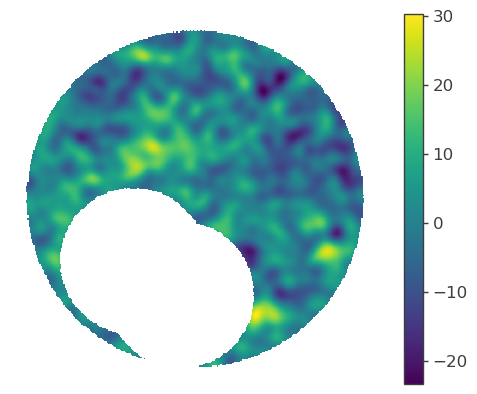

In [6]:
#####   Data Initialize

# maptree = "../../data/gcd_new.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
# maptree =  "../../data/20210305-20230731_trans_fromhsc.root"
# maptree =  "../../data/WCDA_20240131_out.root"

# response = "../../data/DR_ihep_MK2.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

# response = "/data/home/cwy/Science/3MLWCDA/data/DR_ihep_20240131_Crabpsf_mc.root"
# response = "../../data/DR_ihep_MK2_newoldDRpsf.root"
# response = "../../data/WCDA_DR_psf.root"
# response = "../../data/DR_ihep_mk_luoyu.root"
# response = "../../data/DR_ihep_mk_MC1.root"
# response = "../../data/DR_ihep_mk_MC2.root"
# response = "../../data/DR_ihep_MK2_luoyu.root"

maptree = f"{my.libdir}/../../data/skymapDR_latest/20240731_hsc_out.root"
response= f"{my.libdir}/../../data/skymapDR_latest/DR_ihep_20240131_hscpsf_mc.root"

region_name="S147"
if not os.path.exists(f'{my.libdir}/../res/{region_name}/'):
    os.system(f'mkdir {my.libdir}/../res/{region_name}/')
ra_S147, dec_S147 =   83, 26 #84.60, 28.29
ra1,dec1=ra_S147, dec_S147

data_radius = 7.0
model_radius = 8.0

# roimap = my.getmaskedroi(ra1, dec1, data_radius, [(87.28, 23.90, 2), (83.63, 22.02, 3)])
roimap = my.getmaskedroi(ra1, dec1, data_radius, [(85.78, 23.40, 3), (83.63, 22.02, 3)]) #
roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=roimap)

# roi=HealpixConeROI(ra=ra1,dec=dec1,data_radius=data_radius,model_radius=model_radius) 

WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

#####   Data Situation
%matplotlib inline
WCDA.set_active_measurements(0, 6)
WCDA.display()

fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
fig.show()
fig.savefig(f"{my.libdir}/../res/{region_name}/counts_all.png",dpi=300)

In [ ]:
map2, skymapHeader = hp.read_map("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/Halpha_fwhm06_1024.fits",h=True)
map2 = my.change_coord(map2, ["G","C"])
my.heal2fits(map2, "/data/home/cwy/Science/3MLWCDA/Standard/res/S147/S147_HI_temp.fits", ra_min = 82, ra_max = 88, xsize=0.01, dec_min=26, dec_max=30, ysize=0.01, nside=1024, ifplot=0, check=0, alpha=1, ifnorm=True)
figfits, wcs, fitsdata = my.drawfits(fits_file_path="/data/home/cwy/Science/3MLWCDA/Standard/res/S147/S147_HI_temp.fits")

In [ ]:
%matplotlib inline
bestmodel, result = my.Search(ra1, dec1, data_radius, model_radius,  region_name+"_new_freeDGE0-5", WCDA, roi, 0, 5,freeDGE=1, fromcatalog=1, fixcatall=1)

In [10]:
reload(my)

Load sub from Mystat: : 40it [00:41,  1.03s/it] 
ReLoad Mycatalog:  61%|██████    | 23/38 [00:00<00:00, 215.57it/s]  
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.

Load sub from Mystat: : 40it [00:00, 215.57it/s]                            

Yourlib init successfully!!!


<module 'mylib' from '/data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/__init__.py'>

In [ ]:
Modelname="cat+1ext+1pt_freeDGE_0-6"
if not os.path.exists(f'{my.libdir}/../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir {my.libdir}/../res/{region_name}/{Modelname}/')

lm = my.getcatModel(ra1, dec1, data_radius, model_radius, roi=roi)
with open(f'{my.libdir}/../res/{region_name}/{Modelname}/Model_init.txt', 'w') as f:
    for key, value in lm.parameters.items():
        f.write(f'{key}: {value}\n')

# S147 = my.set_diffusemodel("S147", '/data/home/cwy/Science/3MLWCDA/Standard/res/S147/S147_HI_temp.fits', K=7.3776826e-14, Kb=(1e-17, 1e-10))
S147 = my.setsorce("S147",84.5,28.5, sigma=0.2, sb=(0,5), #sf=True, #raf=True,decf=True,
                indexb=(-4,-1),kb=(1e-16, 1e-12), #indexf=True,
                fitrange=1)

PWN = my.setsorce("PWN",84.5,28.5, #sf=True, #raf=True,decf=True,
                indexb=(-4,-1),kb=(1e-16, 1e-12), #indexf=True,
                fitrange=1)

Diffuse = my.set_diffusebkg(
                ra1, dec1, data_radius, data_radius, name=region_name+"WCDA",
                Kf=False, indexf=False
                )
# lm = Model(S147, PWN, Diffuse)
lm.add_source(S147)
lm.add_source(PWN); lm.add_source(Diffuse)

lm.save(f"{my.libdir}/../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)

lm.display(complete=True)
        

22:52:58 INFO      J0534P2200u in model_radius: 8.0 sf:True pf:True kf:True indexf:True                ]8;id=10320;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=389652;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#515\515]8;;\

         INFO      Spec:                                                                               ]8;id=34882;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=166960;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#580\580]8;;\
                   K=2.11e-12 kb=(1.41e-14, 1.00e-11) index=-2.69 indexb=(-4.00,-1.00)                             

         INFO      Mor: fitrange=0.03                                                                  ]8;id=670395;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=537456;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#590\590]8;;\

         WARNING   We have set the min_value of J0534P2200u.spectrum.main.Powerlaw.K to 1e-99      ]8;id=705985;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=920858;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  because there was a postive transform                                                            

         INFO      J0542P2311u in model_radius: 8.0 sf:True pf:True kf:True indexf:True                ]8;id=33711;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=679620;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#515\515]8;;\

         INFO      Spec:                                                                               ]8;id=128764;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=144310;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#580\580]8;;\
                   K=2.08e-13 kb=(1.39e-15, 3.12e-12) index=-1.95 indexb=(-3.95,-1.00)                             

         INFO      Mor:                                                                                ]8;id=125738;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=425769;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#582\582]8;;\
                   sigma=1.45 sb=(0.01,2.89) fitrange=4.00                                                         

         WARNING   We have set the min_value of J0542P2311u.spectrum.main.Powerlaw.K to 1e-99      ]8;id=516093;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=759676;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  because there was a postive transform                                                            

         WARNING   We have set the min_value of S147.spectrum.main.Powerlaw.K to 1e-99 because     ]8;id=240212;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=569528;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of PWN.spectrum.main.Powerlaw.K to 1e-99 because      ]8;id=531621;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=57061;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  there was a postive transform                                                                    

         INFO      Set diffuse range: [173.8761882515279, 187.8761882515279] [-11.120416922412595,    ]8;id=820905;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=471280;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2359\2359]8;;\
                  11.120416922412595]                                                                              

         INFO      ra dec coner:                                                                      ]8;id=555842;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=924555;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2360\2360]8;;\

         INFO      (72.09565075083303, 27.534654967370326)                                            ]8;id=760036;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=130519;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2361\2361]8;;\

         INFO      (80.74857707241122, 16.372828783120497)                                            ]8;id=19032;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=146784;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2362\2362]8;;\

         INFO      (101.71036418428284, 27.24389435719929)                                            ]8;id=808735;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=567856;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2363\2363]8;;\

         INFO      (94.62577936465718, 39.65607009306031)                                             ]8;id=552793;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=280239;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2364\2364]8;;\

         INFO      total sr: 0.09450243804428704                                                      ]8;id=536828;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=546403;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2403\2403]8;;\
                  ratio: 0.03441567082968896                                                                       

         INFO      integration: 4.7194722588394124e-06                                                ]8;id=817042;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=656045;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2404\2404]8;;\
                  ratio: 0.037243985060463405                                                                      

         INFO      set K to: 6.677691882821321e-13                                                    ]8;id=999051;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=838293;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2405\2405]8;;\

         INFO      diffuse file path:                                                                 ]8;id=613200;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py\Myfit.py]8;;\:]8;id=573464;file:///data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/Myfit.py#2432\2432]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../../../data/Diffusedata/S147              
                  WCDA_dust_bkg_template.fits                                                                      

         WARNING   We have set the min_value of Diffuse.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=47053;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=205012;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  there was a postive transform                                                                    

Model summary:
==============

                  N
Point sources     2
Extended sources  3
Particle sources  0

Free parameters (11):
--------------------

                                      value min_value max_value  \
S147.Gaussian_on_sphere.lon0           84.5      83.5      85.5   
S147.Gaussian_on_sphere.lat0           28.5      27.5      29.5   
S147.Gaussian_on_sphere.sigma           0.2       0.0       5.0   
S147.spectrum.main.Powerlaw.K           0.0       0.0       0.0   
S147.spectrum.main.Powerlaw.index      -2.6      -4.0      -1.0   
PWN.position.ra                        84.5      83.5      85.5   
PWN.position.dec                       28.5      27.5      29.5   
PWN.spectrum.main.Powerlaw.K            0.0       0.0       0.0   
PWN.spectrum.main.Powerlaw.index       -2.6      -4.0      -1.0   
Diffuse.spectrum.main.Powerlaw.K        0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index -2.733      -4.0      -1.0   

                                                unit  
S147.Gaussian_on_sphere.lon0                     deg  
S147.Gaussian_on_sphere.lat0                     deg  
S147.Gaussian_on_sphere.sigma                    deg  
S147.spectrum.main.Powerlaw.K         keV-1 s-1 cm-2  
S147.spectrum.main.Powerlaw.index                     
PWN.position.ra                                  deg  
PWN.position.dec                                 deg  
PWN.spectrum.main.Powerlaw.K          keV-1 s-1 cm-2  
PWN.spectrum.main.Powerlaw.index                      
Diffuse.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
Diffuse.spectrum.main.Powerlaw.index                  

Fixed parameters (17):
---------------------

                                                                                      value  \
J0534P2200u.position.ra                                                               83.62   
J0534P2200u.position.dec                                                              22.01   
J0534P2200u.spectrum.main.Powerlaw.K                                                    0.0   
J0534P2200u.spectrum.main.Powerlaw.piv                                         3000000000.0   
J0534P2200u.spectrum.main.Powerlaw.index                                              -2.69   
J0542P2311u.Gaussian_on_sphere.lon0                                                   86.07   
J0542P2311u.Gaussian_on_sphere.lat0                                                   23.19   
J0542P2311u.Gaussian_on_sphere.sigma                                                   1.45   
J0542P2311u.spectrum.main.Powerlaw.K                                                    0.0   
J0542P2311u.spectrum.main.Powerlaw.piv                                         3000000000.0   
J0542P2311u.spectrum.main.Powerlaw.index                                              -1.95   
S147.spectrum.main.Powerlaw.piv                                                3000000000.0   
PWN.spectrum.main.Powerlaw.piv                                                 3000000000.0   
Diffuse.SpatialTemplate_2D.K                                                            1.0   
Diffuse.SpatialTemplate_2D.hash           1389017525880140579864566943032514317764923839...   
Diffuse.SpatialTemplate_2D.ihdu                                                         0.0   
Diffuse.spectrum.main.Powerlaw.piv                                             3000000000.0   

                                         min_value max_value            unit  
J0534P2200u.position.ra                     83.588    83.652             deg  
J0534P2200u.position.dec                    21.978    22.042             deg  
J0534P2200u.spectrum.main.Powerlaw.K           0.0       0.0  keV-1 s-1 cm-2  
J0534P2200u.spectrum.main.Powerlaw.piv        None      None             keV  
J0534P2200u.spectrum.main.Powerlaw.index      -4.0      -1.0                  
J0542P2311u.Gaussian_on_sphere.lon0          82.07     90.07             deg  
J0542P2311u.Gaussian_on_sphere.lat0          19.19     27.19        

Load sub from Mystat: : 40it [00:14, 215.57it/s]

In [39]:
reload(my)

Load sub from Mystat: : 40it [05:10,  7.76s/it] 
ReLoad Mycatalog:  61%|██████    | 23/38 [00:00<00:00, 151.70it/s] 
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.

Load sub from Mystat: : 40it [00:00, 127.08it/s]                            

Yourlib init successfully!!!


<module 'mylib' from '/data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/__init__.py'>

In [40]:
result, lmini, lmopt = my.load_modelpath(f"{my.libdir}/../res/S147-q-Tf-roi8/1pt+1ext_2-6_4-13_roi8_new_all_LP_hsc")

23:35:36 WARNING   The current value of the parameter K (1.0) was above the new maximum 1e-22.     ]8;id=439278;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=865101;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=972818;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=106410;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter beta (1.0) was above the new maximum 0.2.    ]8;id=251526;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=104574;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.91.  ]8;id=332651;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=127924;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.76.  ]8;id=784345;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=816585;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 1.0.  ]8;id=892596;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=498859;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=47436;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=453983;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 83.45.  ]8;id=450622;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=709403;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 35.22.  ]8;id=513676;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=97755;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 3.0.  ]8;id=825911;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=635915;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=397246;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=31173;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=918488;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=304013;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=959232;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=358537;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.5.   ]8;id=432695;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=178307;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 27.5.   ]8;id=835295;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=178380;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=85782;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=442961;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=918273;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=440486;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000002e-25.                                                                          

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=436201;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=928143;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  2.9800000000000003e-25.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.69.  ]8;id=898932;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=225449;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.39.  ]8;id=613588;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=788948;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=154117;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=815669;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=95069;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=490531;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

No results found: [Errno 2] No such file or directory: '../../data/S147-q-Tf-roi8_dust_bkg_template.fits'
here /data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../../../data/Diffusedata/S147-q-Tf-roi8_dust_bkg_template.fits


         WARNING   The current value of the parameter K (1.0) was above the new maximum 1e-22.     ]8;id=570897;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=852448;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=773503;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=962006;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter beta (1.0) was above the new maximum 0.2.    ]8;id=100226;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=242046;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.91.  ]8;id=348391;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=33154;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.76.  ]8;id=406696;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=516350;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 1.0.  ]8;id=139413;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=268298;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=335134;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=938356;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 83.45.  ]8;id=670586;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=610211;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 35.22.  ]8;id=110401;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=435668;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 3.0.  ]8;id=780054;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=773404;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=580408;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=406734;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=210882;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=654182;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=907217;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=84228;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.5.   ]8;id=40909;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=401480;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 27.5.   ]8;id=63348;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=733568;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=475616;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=97014;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=156681;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=117875;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000002e-25.                                                                          

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=366018;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=476148;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  2.9800000000000003e-25.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.69.  ]8;id=94758;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=959526;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.39.  ]8;id=480986;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=623493;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=576275;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=591616;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=18200;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=421140;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

         WARNING   The current value of the parameter K (1.0) was above the new maximum 1e-22.     ]8;id=145806;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=791272;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter beta (1.0) was above the new maximum 0.5.    ]8;id=339905;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=588466;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

here /data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../../../data/Diffusedata/S147-q-Tf-roi8_dust_bkg_template.fits


         WARNING   The current value of the parameter K (1.0) was above the new maximum 1e-22.     ]8;id=866313;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=48835;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=860869;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=289761;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter beta (1.0) was above the new maximum 0.2.    ]8;id=855277;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=472988;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.91.  ]8;id=649970;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=466291;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.76.  ]8;id=531934;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=22374;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 1.0.  ]8;id=277221;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=141713;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=590524;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=883657;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 83.45.  ]8;id=226308;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=995244;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 35.22.  ]8;id=652517;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=479796;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 3.0.  ]8;id=100926;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=249521;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=449005;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=127987;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter alpha (-2.0) was above the new maximum -2.5. ]8;id=867347;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=810571;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=933095;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=3484;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000001e-24.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.5.   ]8;id=784872;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=387711;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 27.5.   ]8;id=518897;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=83713;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=422920;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=839965;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=779690;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=204752;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000002e-25.                                                                          

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=808432;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=50930;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  2.9800000000000003e-25.                                                                          

         WARNING   The current value of the parameter lon0 (0.0) was below the new minimum 84.69.  ]8;id=534573;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=115900;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter lat0 (0.0) was below the new minimum 22.39.  ]8;id=845508;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=734990;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#707\707]8;;\

         WARNING   The current value of the parameter sigma (10.0) was above the new maximum 2.0.  ]8;id=966912;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=589806;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter K (1.0) was above the new maximum            ]8;id=748160;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=121238;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\
                  1.0000000000000003e-23.                                                                          

         WARNING   The current value of the parameter K (1.0) was above the new maximum 1e-22.     ]8;id=352755;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=973809;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

         WARNING   The current value of the parameter beta (1.0) was above the new maximum 0.5.    ]8;id=414521;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=443295;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#777\777]8;;\

23:35:46 INFO      Considering 7 dec bins for extended source J0542                ]8;id=332306;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=399397;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 23.319                      ]8;id=776990;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=714930;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 7 dec bins for extended source J0534P3533           ]8;id=421410;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=342104;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 31.858                      ]8;id=721994;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=82518;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 11 dec bins for extended source S147                ]8;id=237285;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=146902;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 28.050                      ]8;id=9088;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=806342;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 11 dec bins for extended source unexp               ]8;id=621269;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=852758;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 23.219                      ]8;id=724934;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=438164;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=15426;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=669364;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 25.953                      ]8;id=568220;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=950646;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

Load sub from Mystat: : 40it [00:16, 127.08it/s]
WARNING RuntimeWarning: invalid value encountered in sqrt

setting the output map dtype to [dtype('float64')]


(80.33203125, 21.181783147580887)


<Figure size 640x480 with 0 Axes>

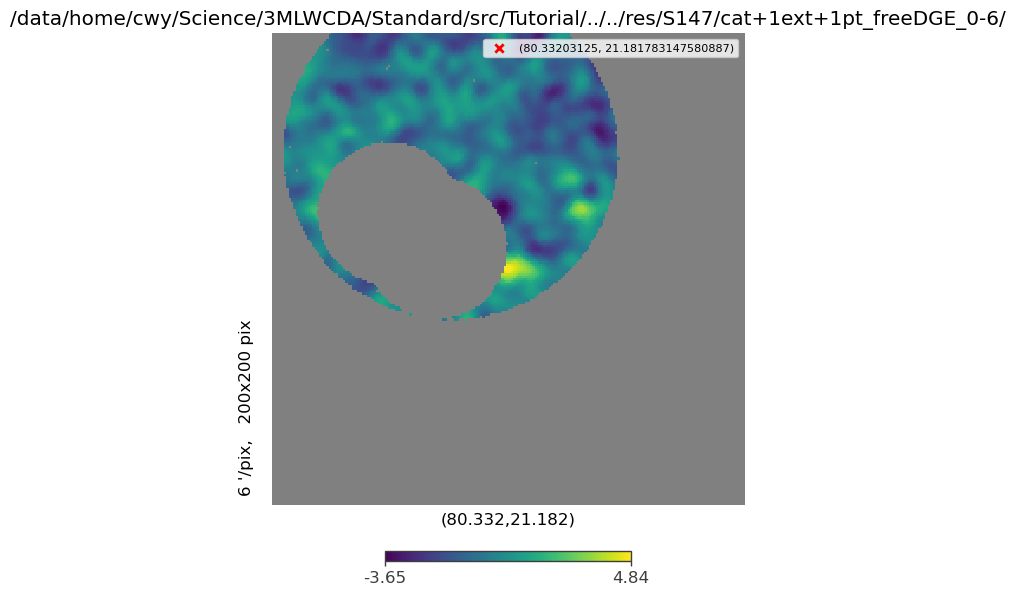

(masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=-1.6375e+30),
 (80.33203125, 21.181783147580887))

<Figure size 640x480 with 0 Axes>

In [41]:
my.getresaccuracy(WCDA, lmopt, plot=True, savepath=f"{my.libdir}/../res/{region_name}/{Modelname}/")

In [109]:
reload(my)

Load sub from Mystat: : 40it [14:07, 21.19s/it]]
Load sub from Mystat: : 40it [00:01, 20.31it/s]                            

Yourlib init successfully!!!


<module 'mylib' from '/data/home/cwy/Science/3MLWCDA/Standard/src/Tutorial/../mylib/__init__.py'>

In [ ]:
my.get_residual_significance_mapfast(WCDA, lm=None, combine='none', plot=True, savepath=f"{my.libdir}/../res/{region_name}/{Modelname}/", smooth_sigma=0.3)

Using user-provided alpha: 3.24e-05


In [ ]:
%matplotlib inline
result = my.fit(region_name, Modelname, WCDA, lm, 0, 6,mini="ROOT")
sources = my.get_sources(lm,result)
result[1][0]
# result[0].get_contours(J0248.Gaussian_on_sphere.lon0,39.88,44.88,30)

In [ ]:
TSlist = ["S147", "PWN", "Diffuse"] #
TS, TSresults = my.getTSall(TSlist, region_name, Modelname, result, WCDA)
TSresults

In [ ]:
reload(my)

PSR:  1 79.29166666666666 22.266666666666666 J0517+22
PSR:  2 82.21774999999998 22.00111111111111 J0528+2200
PSR:  3 83.63320833333333 22.01447222222222 J0534+2200
PSR:  4 84.60441666666665 28.28588888888889 J0538+2817
PSR:  5 85.15466666666666 32.127027777777776 J0540+3207
PSR:  6 85.79025 23.484722222222224 J0543+2329
PSR:  7 86.61983333333332 24.689166666666665 J0546+2441
PSR:  8 88.52087499999999 31.128055555555555 J0554+3107
SNR:  1 81.27083333333333 28.183333333333334 G178.2-04.2 0
SNR:  2 83.62916666666665 22.016666666666666 G184.6-05.8 0
SNR:  3 84.75 27.833333333333332 G180.0-01.7 0
SNR:  4 88.41666666666664 31.083333333333332 G179.0+02.6 0
3FHL:  1 75.25725 24.423498 3FHL J0501.0+2425
3FHL:  2 75.41394 30.795534 3FHL J0501.6+3047
3FHL:  3 80.44172 21.213364 3FHL J0521.7+2112
3FHL:  4 81.13713 28.639719 3FHL J0524.5+2838
3FHL:  5 83.634834 22.019203 3FHL J0534.5+2201
3FHL:  6 84.41 27.86 3FHL J0537.6+2751e
3FHL:  7 87.29354 32.967197 3FHL J0549.1+3258
3FHL:  8 89.91721 30.7621

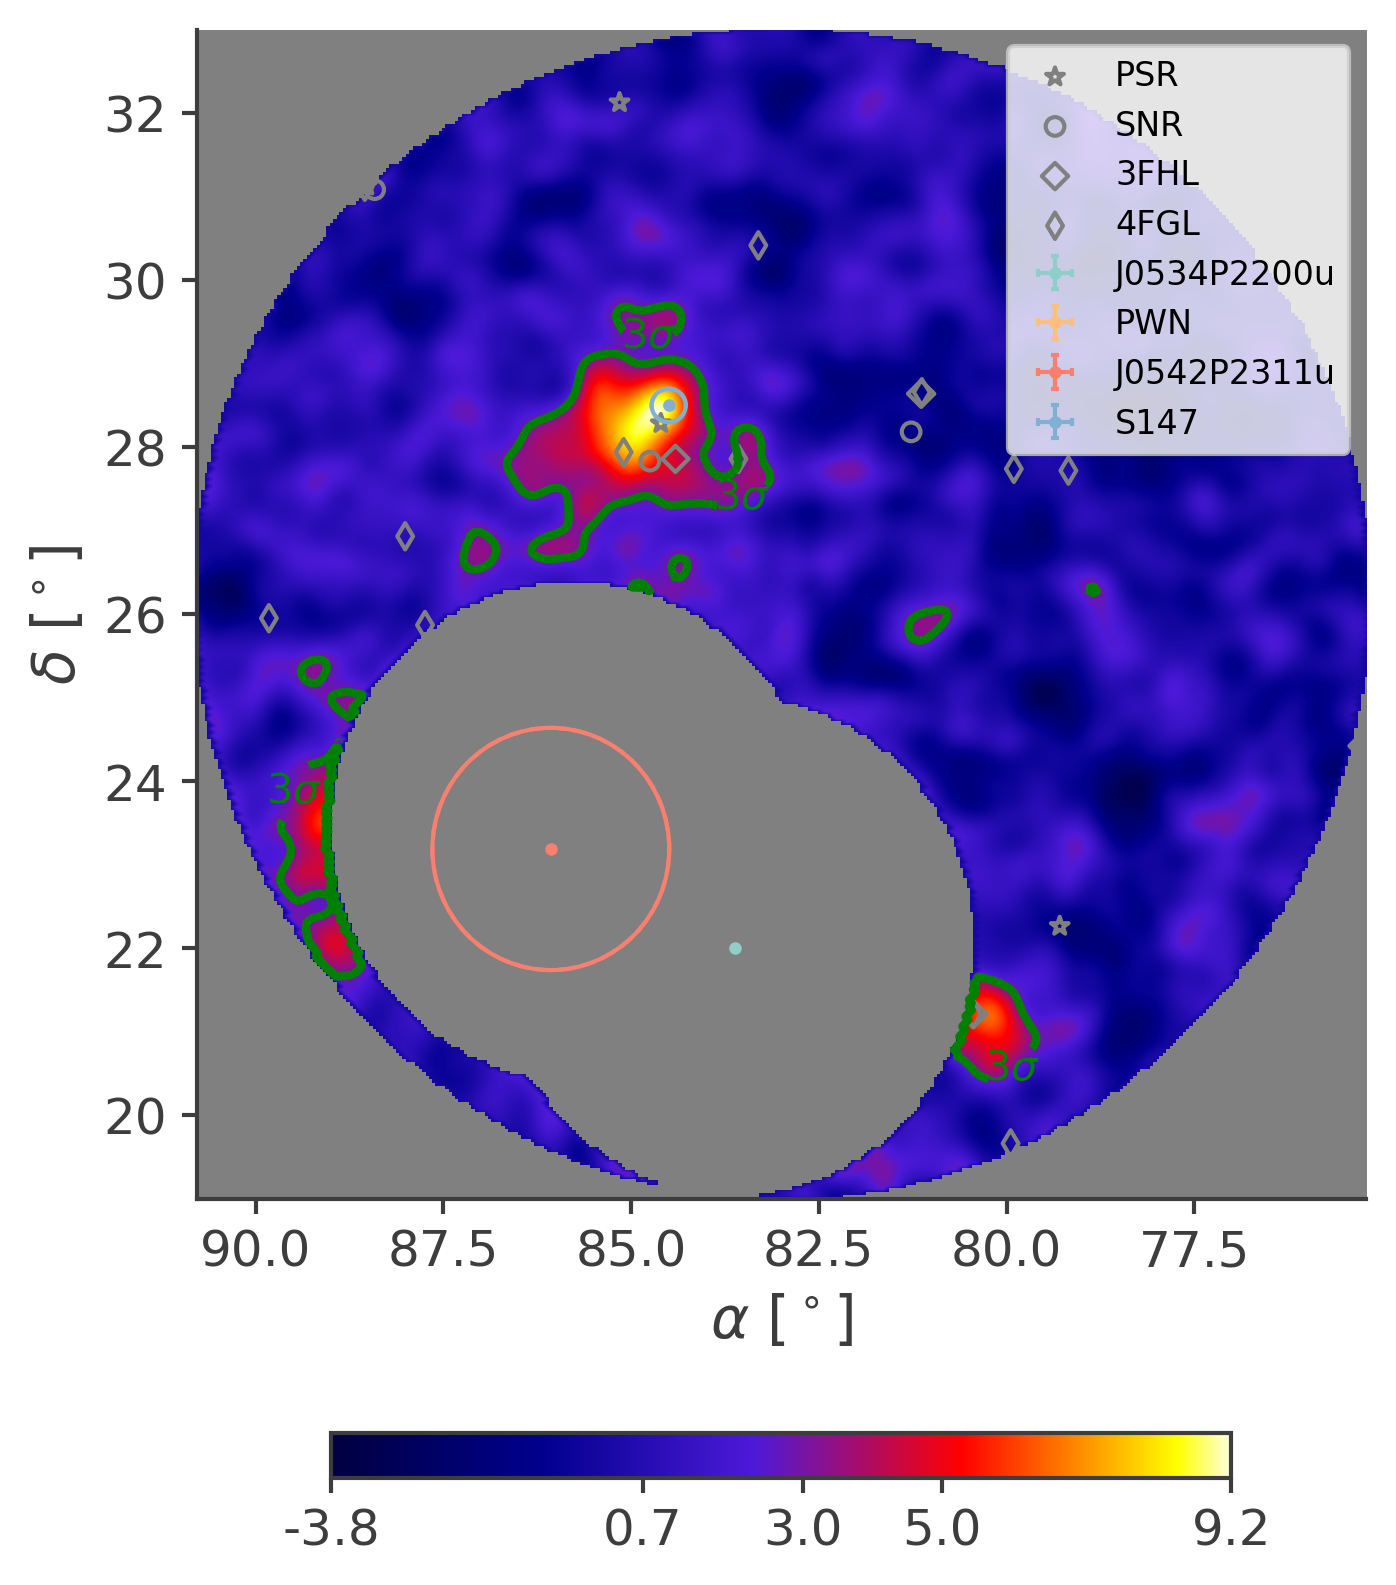

In [87]:
%matplotlib inline
sources = my.get_sources(lm,result) #
sources.pop("Diffuse")
# sources.pop("S147")
# sources={}

map2, skymapHeader = hp.read_map(f"{my.libdir}/../../data/sigmap_latest/fullsky_WCDA_20240731_0-6_2.6.fits.gz",h=True)
map2 = my.maskroi(map2, roi)

fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[3],save=1, 
                cat={"PSR": [0, "*"],"SNR": [0, "o"],"3FHL": [0, "D"],"4FGL": [0, "d"],"size": 20,"markercolor": "grey","labelcolor": "black","angle": 60,"catext": 1  }, #
                # cat={ "LHAASO": [0, "P"],"TeVCat": [0, "s"],"PSR": [0, "*"],"SNR": [0, "o"],"3FHL": [0, "D"], "4FGL": [0, "d"], "YMC": [0, "^"], "GYMC":[0, "v"], "WR":[0, "X"], "size": 20, "color": "grey", "angle": 60, "catext": 1}, #2*data_radius
                # color="Milagro"
                  color="Fermi",
                  # Drawdiff=1, legend=0,
                  # ifdrawfits=1, cutl=0, alphaf=1, fitsfile="/data/home/cwy/Science/3MLWCDA/Standard/res/S147/S147_HI_temp.fits" #, vmin=-15, vmax=30, #
                  )
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')

In [ ]:
my.write_resmap(region_name, Modelname, WCDA, roi, maptree, ra1, dec1, "S147_res_all",[0],[0,0])

In [ ]:
Flux_WCDA0, jls0  = my.getdatapoint(WCDA, lm, maptree, response, roi, "S147", ifpowerlawM=1)
Flux_WCDA1, jls1  = my.getdatapoint(WCDA, lm, maptree, response, roi, "PWN", ifpowerlawM=1)

In [ ]:
%matplotlib inline
import matplotlib as mpl

x_Max=50.
x_Min=0.5
y_Min=0.1e-13
y_Max=8e-12
fig,ax = plt.subplots()
plot_spectra(
    result[0].results,
    sources_to_use=["S147","PWN"], # 
    include_extended=True,
    ene_min=x_Min,
    ene_max=x_Max,
    num_ene=30,
    energy_unit="TeV",
    flux_unit="TeV/(s cm2)",
    subplot=ax,
    )

my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA0,"S147","tab:blue")
my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA1,"PWN","tab:red")

# LHAASO_sensitivity = np.genfromtxt("./LHAASO_sensitivity.csv",delimiter=',')
# plt.plot(LHAASO_sensitivity[:,0],LHAASO_sensitivity[:,1]*1e-11,label="LHAASO 1yr", c="black")

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
plt.legend()
plt.savefig(f'{my.libdir}/../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
plt.savefig(f'{my.libdir}/../res/{region_name}/{Modelname}/Spectrum.pdf')